# E-89 Final Project Code

#### Andrew Merz

### Topic:  Predicting Heart Attack (Myocardial Infarction) Incidence in the Health and Retirement Survey (HRS)

**The code in this file is used to read the raw survey data, add all necessary variables, and perform initial cleaning**

**WARNING**: THIS CODE WILL NOT WORK IF EXECUTED BECAUSE IT REQUIRES A NUMBER OF DATA FILES THAT WERE NOT UPLOADED DUE TO THEIR SIZE.  These files can be downloaded from http://hrsonline.isr.umich.edu/index.php?p=avail&_ga=2.86391320.1078637040.1557700423-150374021.1556499097 (requires creating an account to download, which anyone can do to access the publicly available data).

In [1]:
# Load required libraries and functions
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import copy
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from keras import optimizers
from sklearn.model_selection import GridSearchCV

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras import regularizers
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Retrieve the headers and the indices of their values in the data files
def get_headers(file):
    with open('Column Headers/' + file + '.txt') as headers_file:
        headers_data = headers_file.read()
        headers_data = headers_data.split("\n")
        headers_data.remove('')
        output = []
        for row in headers_data:
            header_name, indices = row.split('  ')
            start, stop = indices.split(' - ')
            output.append({'header_name': header_name, 'start': int(start), 'stop': int(stop)})
        return output

# Read the .da data files and extract the correct data for each column (using the column header data)
def read_data(directory, file):
    header_data = get_headers(file)
    output_data = []
    with open('Data/' + directory + '/' + file + '.da') as data_file:
        data = data_file.read().split("\n")
        data.remove('')
        for r in data:
            row_data = {}
            for hr in header_data:
                row_data[hr['header_name']] = r[hr['start'] - 1:hr['stop']]
            output_data.append(row_data)
    return pd.DataFrame(output_data)

In [3]:
# Read the data for the baseline year (2010)
df = read_data(directory='h10da', file='H10C_R')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22034 entries, 0 to 22033
Columns: 252 entries, HHID to PN
dtypes: object(252)
memory usage: 42.4+ MB
None


,HHID,LSUBHH,MC001,MC002,MC005,MC006,MC008,MC009,MC010,MC011,...,MC276,MC277,MCSR,MFAMR,MFINR,MPN_SP,MSUBHH,MVDATE,MVERSION,PN
0,000003,0,3,3,5,,,,5,,...,,,5,5,1,020,0,7,5.1,010
1,000003,0,4,3,5,,,,5,,...,,,1,1,5,010,0,7,5.1,020
2,010001,0,3,2,5,,,,5,,...,,,1,1,1,011,0,7,5.1,010
3,010003,0,3,1,1,1,1,1,5,,...,,,1,1,1,,0,2,5.1,030
4,010004,0,4,2,1,1,1,2,5,,...,,,1,5,1,040,0,5,5.1,010


In [4]:
# Read in the tracker file data
trk = read_data(directory='trk2016', file='TRK2016TR_R')
print(trk.info())
trk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43222 entries, 0 to 43221
Columns: 469 entries, AAGE to YRENTER
dtypes: object(469)
memory usage: 154.7+ MB
None


,AAGE,AALIVE,ACOUPID,ACOUPLE,ADAMS1,AFAMR,AFINR,AINSAMP,AIWLANG,AIWMODE,...,VA13,VBS16COMPLETE,VBS16CONSENT,VBS16ELIG,VBS16SELECT,VBS16SUBELIG,VBS16VALID,VERSION,WTCOHORT,YRENTER
0,054,1,010000,5,99,1,1,1,1,1,...,99,,,,,,,2,041,1992
1,057,1,010000,5,99,1,1,1,1,1,...,99,,,,,,,2,036,1992
2,056,1,010020,1,99,5,1,1,1,1,...,99,,,0,1,,,2,036,1992
3,054,1,010020,1,99,1,5,1,1,1,...,99,,,0,1,,,2,041,1992
4,053,1,010000,5,99,1,1,1,1,1,...,99,,0,1,1,,,2,041,1992


In [5]:
# Join the tracker file data to the 2010 wave data
df = df.merge(trk, on=['HHID', 'PN'], how='left')
print(df.shape)

(22034, 719)


In [6]:
# Iterate over each survey and exit survey since 2010 and check whether they had a heart attack since the last survey
# Print file specs while doing merge
data_file_maps = {
    'h12da': 'H12C_R', 'x12da': 'X12C_R', 
    'h14da': 'H14C_R', 'x14da': 'X14C_R', 
    'h16da': 'H16C_R', 'x16da': 'X16C_R'
}
C040_cols = []
C257_cols = []
C258_cols = []
C259_cols = []
for directory, file in data_file_maps.items():
    d = read_data(directory, file)
    print('directory:', directory)
    print('file:', file)
    print('N:', d.shape)
    C040 = [col for col in d.columns if 'C040' in col] # heart attack indicator contains string 'C040'
    print('C040 cols:', C040)
    C040_cols += C040
    C257 = [col for col in d.columns if 'C257' in col] # heart attack indicator contains string 'C257'
    print('C257 cols:', C257)
    C257_cols += C257
    C258 = [col for col in d.columns if 'C258' in col] # heart attack indicator contains string 'C258'
    print('C258 cols:', C258)
    C258_cols += C258
    C259 = [col for col in d.columns if 'C259' in col] # heart attack indicator contains string 'C259'
    print('C259 cols:', C259)
    C259_cols += C259
    d = d[['HHID', 'PN'] + C040 + C257 + C258 + C259]
    print(d.shape)
    df = df.merge(d, how='left', on=['HHID', 'PN'])
    print(df.shape)
    print('-' * 50)

directory: h12da
file: H12C_R
N: (20554, 250)
C040 cols: ['NC040']
C257 cols: ['NC257']
C258 cols: ['NC258']
C259 cols: ['NC259']
(20554, 6)
(22034, 723)
--------------------------------------------------
directory: x12da
file: X12C_R
N: (1187, 84)
C040 cols: ['XC040']
C257 cols: ['XC257']
C258 cols: ['XC258']
C259 cols: ['XC259']
(1187, 6)
(22034, 727)
--------------------------------------------------
directory: h14da
file: H14C_R
N: (18747, 227)
C040 cols: ['OC040']
C257 cols: ['OC257']
C258 cols: ['OC258']
C259 cols: ['OC259']
(18747, 6)
(22034, 731)
--------------------------------------------------
directory: x14da
file: X14C_R
N: (1242, 81)
C040 cols: ['YC040']
C257 cols: ['YC257']
C258 cols: ['YC258']
C259 cols: ['YC259']
(1242, 6)
(22034, 735)
--------------------------------------------------
directory: h16da
file: H16C_R
N: (20918, 240)
C040 cols: ['PC040']
C257 cols: ['PC257']
C258 cols: ['PC258']
C259 cols: ['PC259']
(20918, 6)
(22034, 739)
--------------------------------

In [7]:
# See the distribution of heart attack indicators across each survey wave
for i in range(len(C040_cols)):
    print(C040_cols[i])
    print(C257_cols[i])
    d = df.groupby([C040_cols[i], C257_cols[i]])[['HHID']].count().reset_index()
    print(pd.pivot_table(d, values='HHID', index=C040_cols[i], columns=C257_cols[i], aggfunc='sum'))
    print('-' * 50)

NC040
NC257
NC257               1       5     8
NC040                              
       15118.0  297.0  2638.0  66.0
1         79.0   92.0     NaN   NaN
5        535.0  943.0     NaN   NaN
8          3.0   10.0     NaN   NaN
--------------------------------------------------
XC040
XC257
XC257             1      5     8
XC040                           
       480.0   37.0  281.0  23.0
1       10.0   45.0    NaN   NaN
5       19.0  108.0    NaN   NaN
8        NaN    2.0    NaN   NaN
--------------------------------------------------
OC040
OC257
OC257               1       5     8
OC040                              
       13471.0  287.0  2458.0  53.0
1         96.0   84.0     NaN   NaN
5        571.0  812.0     NaN   NaN
8         15.0    7.0     NaN  20.0
--------------------------------------------------
YC040
YC257
YC257             1      5     8
YC040                           
       554.0   56.0  327.0  30.0
1        9.0   36.0    NaN   NaN
5       18.0  128.0    NaN   NaN
8   

In [8]:
# Check how many patients weren't followed up in ANY of the surveys after 2010 (including exit surveys)
(df[C040_cols + C257_cols + C258_cols + C259_cols].isnull().sum(axis=1) == len(C040_cols + C257_cols + C258_cols + C259_cols)).value_counts(dropna=False)

False    21326
True       708
dtype: int64

There are 708 people that were apparently lost to follow-up--they have no information recorded in any survey wave after 2010, whether regular or exit. These will be excluded from the analysis.

In [9]:
# Exclude the respondents that were never followed up with after the 2010 wave (in neither the regular or exit surveys)
print(len(df))
df = df[~(df[C040_cols + C257_cols + C258_cols + C259_cols].isnull().sum(axis=1) == len(C040_cols + C257_cols + C258_cols + C259_cols))]
print(len(df))

22034
21326


In [10]:
# Create response variable (heart attack/myocardial infarction=1, no heart attack=0)
num_reg = re.compile('\d+')
MI_outcomes = []
for r in df.to_dict('records'):
    MI = 'No heart attack'
    for i in range(len(C040_cols)):
        if r[C040_cols[i]] == '1':
            MI = 'Heart attack (case 1)'
            break
        elif num_reg.fullmatch(str(r[C258_cols[i]])) and (r[C258_cols[i]] not in ['9998', '9999']) and num_reg.fullmatch(str(r[C259_cols[i]])) and (r[C259_cols[i]] not in ['98', '99']):
            if r[C257_cols[i]] == '1' and int(r[C258_cols[i]]) > 2010 or (int(r[C258_cols[i]]) == 2010 and int(r[C259_cols[i]]) > int(r['MIWMONTH'])):
                MI = 'Heart Attack (case 2)'
                break
    MI_outcomes.append(MI)
    
df['heart_attack_semifinal'] = MI_outcomes
print(df['heart_attack_semifinal'].value_counts(dropna=False))

No heart attack          20266
Heart attack (case 1)      721
Heart Attack (case 2)      339
Name: heart_attack_semifinal, dtype: int64


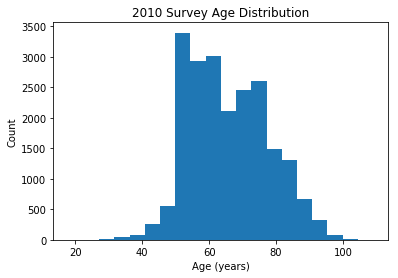

True     20376
False      950
Name: 2010_age, dtype: int64


In [11]:
df['gender'] = df['GENDER'].map({'1': 'male', '2': 'female', '': None})
df['hispanic'] = df['HISPANIC'].map({'0': None, '1': 'hispanic', '2': 'hispanic', '3': 'hispanic', '5': 'non-hispanic'})
df['race'] = df['RACE'].map({'0': None, '1': 'white', '2': 'black', '7': 'other'})
df['2010_age'] = pd.to_numeric(df['MAGE'])

plt.hist(df['2010_age'], bins=20)
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.title('2010 Survey Age Distribution')
plt.show()
print((df['2010_age'] >= 50).value_counts(dropna=False))

In [12]:
# Filter by age
# Due to the rather small number of people under the age of 50, I will exclude everyone under 50
print(len(df))
df = df[df['2010_age'] >= 50]
print(len(df))
print(df['heart_attack_semifinal'].value_counts(dropna=False))

21326
20376
No heart attack          19334
Heart attack (case 1)      705
Heart Attack (case 2)      337
Name: heart_attack_semifinal, dtype: int64


In [13]:
# Compute summary statistics on heart disease incidence and compare with benchmarks to see if they're reasonable
def ag1(age):
    if age < 45:
        return '0-44'
    elif age < 55:
        return '45-54'
    elif age < 65:
        return '55-64'
    elif age < 75:
        return '65-74'
    elif age < 85:
        return '75-84'
    else:
        return '85+'
    
df['ag1'] = df['2010_age'].apply(ag1)
df['ag1'].value_counts(dropna=False)

55-64    6334
65-74    5346
75-84    3767
45-54    3396
85+      1533
Name: ag1, dtype: int64

In [14]:
# Compute summary statistics on heart disease incidence and compare with benchmarks to see if they're reasonable
def ag2(age):
    if age < 50:
        return '0-50'
    elif age < 60:
        return '50-59'
    elif age < 70:
        return '60-69'
    elif age < 80:
        return '70-79'
    elif age < 90:
        return '80-89'
    else:
        return '90+'
    
df['ag2'] = df['2010_age'].apply(ag2)
df['ag2'].value_counts(dropna=False)

50-59    6954
70-79    5287
60-69    5116
80-89    2458
90+       561
Name: ag2, dtype: int64

In [15]:
# Create the final heart attack outcome variable:  0 if no heart attack, 1 if heart attack within the 6-year window
df['heart_attack'] = df['heart_attack_semifinal'].map({'No heart attack': 0, 'Heart attack (case 1)': 1, 'Heart Attack (case 2)': 1})
df['heart_attack'].value_counts(dropna=False)

0    19334
1     1042
Name: heart_attack, dtype: int64

In [16]:
# sns.catplot("alive", col="deck", col_wrap=4, data=titanic[titanic.deck.notnull()], kind="count")
gb1 = df.groupby(['ag1', 'gender'])[['heart_attack']].mean() * 1000
gb1
# .reset_index()
# pd.pivot_table()

heart_attack
ag1   gender              
45-54 female     33.609100
      male       42.407661
55-64 female     29.763561
      male       48.192771
65-74 female     43.435341
      male       80.190724
75-84 female     57.800752
      male       77.486272
85+   female     59.236948
      male       93.109870

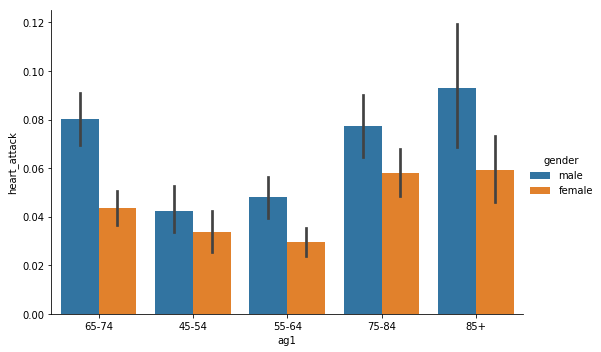

In [17]:
# sns.barplot(x="ag1", y="heart_attack", hue="gender", data=df, estimator='mean');
sns.factorplot(x="ag1", y="heart_attack", hue="gender", data=df, kind="bar", aspect=1.5);

In [18]:
df.groupby(['gender'])[['heart_attack']].mean() * 100

,heart_attack
gender,
female,4.156688
male,6.402579


## Select Predictor Variables

Recode categorical predictor variables as strings first, so you can easily interpret the initial descriptive statistics.

According to [this](https://www.mayoclinic.org/diseases-conditions/heart-attack/symptoms-causes/syc-20373106) website, these are major risk factors for a heart attack (myocardial infarction):
- Age
- Tobacco
- High blood pressure
- High blood cholesterol (particularly LDL and triglycerides)
- Obesity
- Diabetes
- Metabolic syndrome:  high blood pressure + obesity + high blood sugar (i.e., diabetes)
- Family history of heart attack
- Lack of physical activity
- Stress
- Illicit drug use:  particularly stimulants, like cocaine and amphetamines
- History of preeclampsia
- Autoimmune condition

A number of demographic and non-heart disease specific health variables will also be selected for inclusion.

In [19]:
# Merge in necessary reference data from external files
def join_external_data(df):
    
    output = df[:]
    
    pm = read_data(directory='h10da', file='H10I_R')
    print(pm.shape)
    print(output.shape)
    output = output.merge(pm[['HHID', 'PN', 'MI834', 'MI841']], how='left', on=['HHID', 'PN'])
    print(output.shape)
    
    print('-' * 50)
    pm08 = read_data(directory='h08da', file='H08I_R')
    print(pm08.shape)
    print(output.shape)
    output = output.merge(pm08[['HHID', 'PN', 'LI834', 'LI841']], how='left', on=['HHID', 'PN'])
    print(output.shape)
    
    print('-' * 50)
    pm06 = read_data(directory='h06da', file='H06I_R')
    print(pm06.shape)
    print(output.shape)
    output = output.merge(pm06[['HHID', 'PN', 'KI834', 'KI841']], how='left', on=['HHID', 'PN'])
    print(output.shape)
    
    print('-' * 50)
    d08 = read_data(directory='h08da', file='H08C_R')
    print(d08.shape)
    print(output.shape)
    output = output.merge(d08[['HHID', 'PN', 'LC141', 'LC142', 'LC139', 'LC040', 'LC045']], how='left', on=['HHID', 'PN'])
    print(output.shape)
    
    print('-' * 50)
    d06 = read_data(directory='h06da', file='H06C_R')
    print(d06.shape)
    print(output.shape)
    output = output.merge(d06[['HHID', 'PN', 'KC141', 'KC142', 'KC139', 'KC040', 'KC045']], how='left', on=['HHID', 'PN'])
    print(output.shape)

    print('-' * 50)
    b06 = read_data(directory='h10da', file='H10B_R')
    print(b06.shape)
    print(output.shape)
    output = output.merge(b06[['HHID', 'PN', 'MB082']], how='left', on=['HHID', 'PN'])
    print(output.shape)

    print('-' * 50)
    n06 = read_data(directory='h10da', file='H10N_R')
    print(n06.shape)
    print(output.shape)
    output = output.merge(n06[['HHID', 'PN', 'MN360', 'MN365']], how='left', on=['HHID', 'PN'])
    print(output.shape)

    return output

df2 = join_external_data(df)

(22034, 187)
(20376, 751)
(20376, 753)
--------------------------------------------------
(17217, 186)
(20376, 753)
(20376, 755)
--------------------------------------------------
(18469, 180)
(20376, 755)
(20376, 757)
--------------------------------------------------
(17217, 229)
(20376, 757)
(20376, 762)
--------------------------------------------------
(18469, 208)
(20376, 762)
(20376, 767)
--------------------------------------------------
(22034, 184)
(20376, 767)
(20376, 768)
--------------------------------------------------
(22034, 345)
(20376, 768)
(20376, 770)


### Write Combined Data to File

This data will be read and used in the **Final Project Code.ipynb** file.

In [22]:
# df2.to_csv('full_joined_data.csv', index=False)
df3 = df2.sample(frac=0.02)
print(df3.info())
df3.to_csv('mini_joined_data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408 entries, 3740 to 13055
Columns: 770 entries, HHID to MN365
dtypes: int64(2), object(768)
memory usage: 2.4+ MB
None
